# On Mining Multi-Time-Interval Sequential Patterns

### Submitted By,
1. Rajath C Aralikatti , 181CO241
2. Sangeeth S V , 181CO246

This project is an implementation based on the paper titled 'On mining multi-time-interval sequential patterns'. Few optimizations have been made in our implementation that improve runtime and memory utilization when compared to the original implementations described by the authors.

Link to the original paper - https://www.sciencedirect.com/science/article/abs/pii/S0169023X09000809

#####Data mining is the process by which previously unknown, potentially usable data is extracted from databases. It has been established that patterns occur frequently in large databases and several papers have been published about mining such sequential patterns. However, these algorithms for mining sequential patterns cannot establish the timeframe between two sequential events. Therefore, the focus shifted toward mining time-interval sequential patterns. Two approaches were proposed each having their own drawbacks. 
1. Setting fixed time frames for each event, which has the drawback of having no exact measure of the time interval.
2. Measuring the exact time interval between successive events, with the drawback of having no way to measure the time between non-successive events.

##### Improving upon these became necessary. To that end, Ya-Han Hu et. al. in their paper, "On mining multi-time-interval sequential patterns", they describe two algorithms, the MI-Apriori Algorithm and the MI-PrefixSpan Algorithm for mining multi-time-interval sequential patterns. In this project, we strive to provide implementations for both these algorithms.

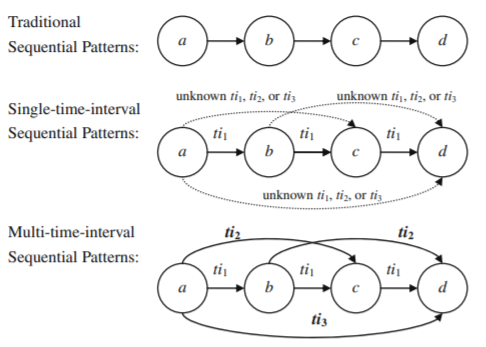

#####For either algorithm to operate, three parameters are necessary.
1. Time Intervals - The values of ti_0, ti_1, ... , ti_n
2. Minimum Support - Only those multi-time intervals are selected which have a support greater than this value.
3. Database - We need a set of data in the form of (item, timestamp), on which we run these algorithms in order to find the multi time interval sequential patterns.

In [ ]:
import sys
from copy import deepcopy as copy
from collections import defaultdict
import random
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
TIME_INTERVALS = [(0, 0), (0, 3), (3, 6), (6, float('inf'))]
MIN_SUP = 0.50
DB = [
	 [('a', 1), ('b', 3), ('c', 3), ('a', 5), ('e', 5), ('c', 10)],
	 [('d', 5), ('a', 7), ('b', 7), ('e', 7), ('d', 8), ('e', 8), ('c', 14), ('d', 15)],
	 [('a', 8), ('b', 8), ('e', 11), ('d', 12), ('b', 13), ('c', 13), ('c', 16)],
	 [('b', 15), ('f', 15), ('e', 16), ('b', 17), ('c', 17)]
   ]
# TIME_INTERVALS = [(0, 5), (5, float('inf'))]
# MIN_SUP = 0.50
# DB = [
# 	 [('a', 1), ('b', 3), ('c', 3), ('a', 5), ('e', 5), ('c', 10)],
# 	 [('d', 5), ('a', 7), ('b', 7), ('e', 7), ('d', 8), ('e', 8), ('c', 14), ('d', 15)],
# 	 [('a', 8), ('b', 8), ('e', 11), ('d', 12), ('b', 13), ('c', 13), ('c', 16)],
# 	 [('b', 15), ('f', 15), ('e', 16), ('b', 17), ('c', 17)]
#    ]

In [ ]:
# To get the time interval information matrix as described in the paper.
def generate_time_interval_information_matrix(ti, show=False):
  """Creating the Time Interval Information Matrix"""
  table = [[[] for i in range(len(ti))] for j in range(len(ti))]
  table[0][0].append(ti[0])

  for i in range(1, len(ti)-1):
    for j in range(i+1):
      left = ti[i][0] + ti[j][0]
      right = ti[i][1] + ti[j][1]

      for t in ti[1:]:
        if left <= t[0] <= t[1] <= right or (left <= t[0] <= t[1] and ti[-1][0]<right<=float('inf')):
          table[i][j].append(t)
  for i in range(len(ti)):
    table[-1][i].append(ti[-1])
  if show:
    print(table)

  return table

# testing
generate_time_interval_information_matrix(ti=TIME_INTERVALS)

[[[(0, 0)], [], [], []],
 [[(0, 3)], [(0, 3), (3, 6)], [], []],
 [[(3, 6)], [(3, 6), (6, inf)], [(6, inf)], []],
 [[(6, inf)], [(6, inf)], [(6, inf)], [(6, inf)]]]

### **Properties of Multi Time Interval Sequence Patterns**

1. ***Descending Property:*** Each successive time interval in each &i of a multi-time interval sequence, is at most equal to the previous time interval. 
For example, (ti3, ti2, ti2,ti1) is valid, whereas, (ti2, ti3, ti2, ti1) is not valid.
2. ***Containing Property:*** A multi-time interval sequence is said to be contained in a data sequence if for every pair of items, the difference in the timestamps is same as that indicated in the multi-time interval sequence pattern. 
For example, {a,(ti1),b,(ti2,ti1),c,(ti2,ti1,ti1),d} is contained in data sequence A = {(a,1),(b,3),(c,5),(d,6),(e,8)} where ti0: 0; ti1: [0,3]; ti2: [3,6]; ti3: [6,∞).
3. ***Anti-Monotonicity Property:*** If a multi-time-interval sequence is frequent, so are all of its subsequences. Accordingly, if a multi-time-interval sequence is not frequent, then its super sequence will not be either. A sequence is said to be frequent if it has more than the minimum support specified for the data.
<br>Support of a multi-time interval sequence pattern is defined as the ratio of number of item sequences in which it is contained to the total number of item sequences in our database. 

In [ ]:
# A class for multi time interval sequences
class multiTimeIntervalSequence:
  """A multi time interval sequence"""
  def __init__(self, items, intervals):
    self.items = items
    self.intervals = intervals
    self.length = len(items)

  def display(self):
    # assert self.items == sorted(self.items), "Assertion Error"
    print("Items: {0}, Intervals: {1}".format(self.items, self.intervals))

  def __hash__(self):
    return hash((tuple(self.items), tuple(tuple(i) for i in self.intervals)))
  
  def __eq__(self, other):
    """Equality operator overloading for Sequence class"""
    return self.length == other.length and self.items == other.items and self.intervals == other.intervals

In [ ]:
# This function returns the interval to which the timestamp belongs.
# For example, for ('a', 3) and ('b', 8), the timestamp calculated would be 8-3 = 5.
# This function would go through the TIME_INTERVALS and get the time interval to which the timestamp 5 would belong.
# In this case, it would be (3, 6).
def get_interval(timestamp, time_intervals=TIME_INTERVALS):
	"""Returns interval corresponding to given timestamp"""
	timestamp = abs(timestamp)

	for interval in time_intervals:
		if timestamp >= interval[0] and timestamp <= interval[1]:
			return interval

# this function takes in the interval and returns the index of that interval in TIME_INTERVALS
def get_interval_index(interval, time_intervals=TIME_INTERVALS):
  """"Returns the index of the interval according to the
	list of intervals"""
  return time_intervals.index(interval)
 
# Testing
print(get_interval(5))
print(get_interval_index(get_interval(5)))

(3, 6)
2


## Multi-Time-Interval Apriori Algorithm - Optimized Implementation based on our Modification

In [ ]:
#@title contains method for apriori algorithm { form-width: "36%" }
# This function takes in a sequence of items and its timestamps and a multi-time-interval-pattern
# and finds out whether the pattern is contained in the sequence.
def contains(transaction, sequence, timeIntervals=TIME_INTERVALS):
  """Returns True if MTI-sequence is contained in transaction/item sequence as per multi-time
  interval sequence's "contains" definition.
  Arguments:
      transaction: A transaction from a sequence database containing
      (item, timestamp) tuples sorted according to timestamp
      sequence: A multi time interval sequence
  """
  # Creating copies so that things don't mess up during recursion
  # Python does pass by reference so doing this to be safe
  unknown_items = copy(sequence.items)
  known_tuples = []

  def recursive_contains(known_tuples, unknown_items, transaction, sequence):
    """recursive_contains

    Arguments:
        known_tuples:
        unknown_items:
        transaction:
        sequence:
    """
    if len(unknown_items) == 0:
      return True
    
    # Finding all the tuples with item equal to the first of the unknown_items list along with its indices.
    # After this, the first of the unknown_items list is discarded for the next recursive call.
    item_tuples_in_transaction = [(item_tuple, index) for index, item_tuple in enumerate(transaction) if item_tuple[0] == unknown_items[0]]

    # index is also required because the items before the current item can no longer play a role in matching with the pattern
    # therefore, only the items with a timestamp greater than the current one is passed to the next recursive call.
  
    for item_tuple, index in item_tuples_in_transaction:
      if not passes_validity(item_tuple, known_tuples, sequence, timeIntervals):
        continue

      cur_known = known_tuples + [item_tuple]
      if recursive_contains(cur_known, unknown_items[1:], transaction[index+1:], sequence):
        return True

    return False
    # end function recursive_contains
  return recursive_contains(known_tuples, unknown_items, transaction, sequence)

# second condition
def passes_validity(item_tuple, known_tuples, sequence, timeIntervals=TIME_INTERVALS):
  """Returns True if item_tuple(item, timestamp) passes the time interval
  validity , i.e the time difference between item and each item in
  known_tuples should belong to the same interval as specified in
  sequence.intervals
  Arguments:
      item_tuple:
      known_tuples:
      sequence:
  """

  # This function checks the second condition for the "contains" definition.
  # It checks the time_interval for each of the previous known tuples and 
  # cross checks it with the intervals specified in the Multi-time-interval-sequence passed to it.

  cur_item, cur_timestamp = item_tuple
  cur_idx = len(known_tuples)
  
  for idx, (item, timestamp) in enumerate(known_tuples):

    cur_interval = get_interval(cur_timestamp - timestamp, time_intervals=timeIntervals)
    if cur_interval != sequence.intervals[cur_idx - 1][idx]:
      return False

  return True

# Testing
# Case 1
transaction_ = [('a', 1), ('b', 3), ('c', 5), ('d', 6), ('e', 8)]
sequence_ = multiTimeIntervalSequence(items=['a', 'b', 'c', 'd'], intervals=[[(0, 3)], [(3, 6), (0, 3)], [(3, 6), (0, 3), (0, 3)]])
print(contains(transaction=transaction_, sequence=sequence_))

# Case 2
transaction_ = [('a', 1), ('b', 3), ('c', 5), ('d', 6), ('e', 8)]
sequence_ = multiTimeIntervalSequence(items=['a', 'b', 'c', 'e'], intervals=[[(0, 3)], [(3, 6), (0, 3)], [(3, 6), (0, 3), (0, 3)]])
print(contains(transaction=transaction_, sequence=sequence_))

# Case 3
transaction_ = [('a', 1), ('b', 3), ('c', 5), ('d', 6), ('e', 8)]
sequence_ = multiTimeIntervalSequence(items=['a', 'b', 'c', 'e'], intervals=[[(0, 3)], [(3, 6), (0, 3)], [(6, float('inf')), (3, 6), (0, 3)]])
print(contains(transaction=transaction_, sequence=sequence_))

True
False
True


In [ ]:
def support(sequence, db, timeIntervals=TIME_INTERVALS, verbose=False):
  """Returns support of multiTimeIntervalSequence sequence in db
  This is equal to number of rows containing sequence
  divided by total number of rows"""
  item_in_rows = 0.0
  num_rows = len(db)
  transactions = []

  for row in db:
    if contains(row, sequence, timeIntervals=timeIntervals):
      item_in_rows += 1
      transactions.append(row)

  if verbose:
    print("The given sequence is present in the following transactions")
    for idx, row in enumerate(transactions):
      print("{0} : {1}".format(idx, row))

  return item_in_rows/num_rows


# items=['a', 'b', 'e']
# ti1=(0,5)
# ti2=(5,float('inf'))
# intervals= [[ti1],[ti2,ti2]]
# sequence_ = multiTimeIntervalSequence(items=items, intervals=intervals)
# support(sequence_, db=DB)*4
# # testing
# sequence_ = multiTimeIntervalSequence(items=['c', 'f', 'b'], intervals=[[(3, 6)], [(6, float('inf')), (0, 3)]])
# support(sequence_, db=DB)

In [ ]:
# To generate distinct elements that satisfy the minimum support requirement.
def generate_one_item_sets(db, min_support):
  """Generates one item sets from a database of data sequences 
  containing data in the form of (item, timestamp) tuples."""
  unique_item_count = {}
  for row in db:
    count = {}
    for item, timestamp in row:
      try:
        count[item] += 1
      except:
        count[item] = 1
    for key in count:
      try:
        unique_item_count[key] += 1
      except:
        unique_item_count[key] = 1

  return list(filter(lambda x: unique_item_count[x]/len(db) >= min_support, unique_item_count.keys()))

# Testing
one_item_sets = generate_one_item_sets(db=DB, min_support=0.5)
one_item_sets

['a', 'b', 'c', 'e', 'd']

In [ ]:
def joinC2(one_itemsets, time_intervals, min_support,db=DB):
  """ Joins 1-multi-time-interval sequences with itself and returns a
  2-multi-time-interval sequence
  Arguments:
      one_itemsets: frequent one itemsets from the DB
      time_intervals: time intervals defined
  """
  list_of_sequences = []
  sequence_hashMap = defaultdict(lambda: False)
  for item_1 in one_itemsets:
    for item_2 in one_itemsets:
      t_items = [item_1, item_2]
      for interval in time_intervals:
        t_intervals = [[interval]]
        mtiseq = multiTimeIntervalSequence(t_items, t_intervals)
        if not sequence_hashMap[mtiseq]:
          sequence_hashMap[mtiseq] = True
          if support(sequence=mtiseq, db=db, timeIntervals=time_intervals) >= min_support:
            list_of_sequences.append(mtiseq)
  return list_of_sequences
# Testing
two_item_sets = joinC2(one_itemsets=one_item_sets, time_intervals=TIME_INTERVALS, min_support=MIN_SUP)
for sequence in two_item_sets:
  sequence.display()
print(len(two_item_sets))

Items: ['a', 'b'], Intervals: [[(0, 0)]]
Items: ['a', 'c'], Intervals: [[(3, 6)]]
Items: ['a', 'c'], Intervals: [[(6, inf)]]
Items: ['a', 'e'], Intervals: [[(0, 0)]]
Items: ['a', 'e'], Intervals: [[(0, 3)]]
Items: ['b', 'c'], Intervals: [[(0, 0)]]
Items: ['b', 'c'], Intervals: [[(0, 3)]]
Items: ['b', 'c'], Intervals: [[(6, inf)]]
Items: ['b', 'e'], Intervals: [[(0, 3)]]
Items: ['e', 'b'], Intervals: [[(0, 3)]]
Items: ['e', 'c'], Intervals: [[(0, 3)]]
Items: ['e', 'c'], Intervals: [[(3, 6)]]
Items: ['e', 'd'], Intervals: [[(0, 3)]]
Items: ['d', 'b'], Intervals: [[(0, 3)]]
Items: ['d', 'c'], Intervals: [[(3, 6)]]
15


In [ ]:
def joinable(k1, k2):
  """Returns True if the two k-multi-time-interval sequence are joinable into
  a k+1-multi-time-interval sequence
  Arguments:
      k1: k-multi-time-interval
      k2: k-multi-time-interval
  """
  if k1.length != k2.length:
    return False
  if k1.items[1:] != k2.items[:-1]:
    return False
  if k1.length == 2: # There wont be any time intervals here to check
    return True
  intervals_1 = []
  for intervals in k1.intervals[1:]:
    intervals_1.append(intervals[1:])
  intervals_2 = k2.intervals[:-1]
  if intervals_1 != intervals_2:
    return False
  return True

In [ ]:
def joinCk(k1, k2, timeIntervalMatrix, min_support, sequence_hashMap, db, time_intervals=TIME_INTERVALS):
  """ Joins two k-multi-time-interval sequences and returns a
  k+1-multi-time-interval sequence
  Arguments:
      k1: k-multi-time-interval
      k2: Another k-multi-time-interval
      timeIntervalMatrix: Time interval matrix constructed using
      time intervals defined
  """
  list_of_sequences = []
  items = copy(k1.items)
  items.append(k2.items[-1])
  intervals = copy(k1.intervals)
  intervals.append(copy(k2.intervals[-1]))
  T_1_kminus1 = k1.intervals[-1][0]
  T_kminus1_k = k2.intervals[-1][-1]
  i = get_interval_index(T_1_kminus1, time_intervals=time_intervals)
  j = get_interval_index(T_kminus1_k, time_intervals=time_intervals)
  if i < j: # Time interval matrix we construct is upper triangular
    i, j = j, i
  # Descending Property + Time Interval Matrix Property
  for interval in timeIntervalMatrix[i][j]:
    # T_1_k should be >= T_2_k
    if get_interval_index(interval, time_intervals=time_intervals) >= get_interval_index(intervals[-1][0], time_intervals=time_intervals):
      t_intervals = copy(intervals)
      t_intervals[-1].insert(0, interval)
      mtiseq = multiTimeIntervalSequence(items, t_intervals)
      if not sequence_hashMap[mtiseq]:
        sequence_hashMap[mtiseq] = True
        if support(sequence=mtiseq, db=db, timeIntervals=time_intervals) >= min_support:
          list_of_sequences.append(mtiseq)
  return list_of_sequences

In [ ]:
#@title Apriori Algorithm - Optimized Implementation based on our Modification { form-width: "20%" }
class MultiTimeIntervalApriori:
    """Implements the Multi Time Interval Apriori Algorithm
    multi-time-interval-sequences will be referred to as MTIS in comments"""

    def __init__(self, db=DB, timeIntervals=TIME_INTERVALS, min_support=MIN_SUP):
      self.__db = db
      self.__timeIntervals = timeIntervals
      self.__timeIntervalMatrix = generate_time_interval_information_matrix(ti=self.__timeIntervals)
      self.__min_sup = min_support
      self.__oneItemsets = generate_one_item_sets(db=self.__db, min_support=self.__min_sup)
      self.__frequentSequences = defaultdict(list)
      self.__time_taken = 0
    
    def getFrequentSequences(self, k=None):
      if k is None:
        return self.__frequentSequences
      return self.__frequentSequences[k]
    
    def find_time_taken(self):
      return self.__time_taken

    def display_count_of_sequences(self, k=None):
      if not k:
        for each in self.__frequentSequences:
          print("{0}-MTIS Sequences Generated: {1}".format(each, len(self.__frequentSequences[each])))
      else:
        print("{0}-MTIS Sequences Generated: {1}".format(k, len(self.__frequentSequences[k])))
    
    def run_multi_time_interval_apriori(self, max_sequence_length=10, verbose=False, measure_time=False):
      """
      Stub function to run the apriori algorithm.
      Arguments:
        max_sequence_length: Maximum multiTimeIntervalSequence length
      """
      for each in self.__oneItemsets:
        self.__frequentSequences[1].append(multiTimeIntervalSequence([each], []))
      self.__time_taken = time.time()
      self.__frequentSequences[2] = joinC2(one_itemsets=self.__oneItemsets, time_intervals=self.__timeIntervals, min_support=self.__min_sup, db=self.__db)
    
      for k in range(3, max_sequence_length + 1):
        # 'Generating {k} - Multi Time Interval Sequences'
        # Get all C_{k-1} MTIS
        kminus1_sequences = self.__frequentSequences[k-1]
        current_ksequence_list = []

        sequence_hashMap = defaultdict(lambda:False)
        for sequence_1 in kminus1_sequences:
          for sequence_2 in kminus1_sequences:
            if joinable(sequence_1, sequence_2):
              # This can generate multiple Ck sequences
              new_k_sequences = joinCk(sequence_1, sequence_2, self.__timeIntervalMatrix, self.__min_sup, sequence_hashMap=sequence_hashMap, db=self.__db, time_intervals=self.__timeIntervals)
              current_ksequence_list += new_k_sequences
        if len(current_ksequence_list) == 0:
          break
        self.__frequentSequences[k] = current_ksequence_list

      if verbose:
        for each in self.__frequentSequences:
          print("{0}-MTIS Sequences Generated".format(each))
          for sequence in self.__frequentSequences[each]:
            sequence.display()

      self.__time_taken = time.time() - self.__time_taken
      if measure_time:
        print("Time Taken: {0}".format(self.__time_taken))

In [ ]:
apriori = MultiTimeIntervalApriori(db=DB, min_support=0.5, timeIntervals=TIME_INTERVALS)

In [ ]:
apriori.run_multi_time_interval_apriori(verbose=True, measure_time=False)

1-MTIS Sequences Generated
Items: ['a'], Intervals: []
Items: ['b'], Intervals: []
Items: ['c'], Intervals: []
Items: ['e'], Intervals: []
Items: ['d'], Intervals: []
2-MTIS Sequences Generated
Items: ['a', 'b'], Intervals: [[(0, 0)]]
Items: ['a', 'c'], Intervals: [[(3, 6)]]
Items: ['a', 'c'], Intervals: [[(6, inf)]]
Items: ['a', 'e'], Intervals: [[(0, 0)]]
Items: ['a', 'e'], Intervals: [[(0, 3)]]
Items: ['b', 'c'], Intervals: [[(0, 0)]]
Items: ['b', 'c'], Intervals: [[(0, 3)]]
Items: ['b', 'c'], Intervals: [[(6, inf)]]
Items: ['b', 'e'], Intervals: [[(0, 3)]]
Items: ['e', 'b'], Intervals: [[(0, 3)]]
Items: ['e', 'c'], Intervals: [[(0, 3)]]
Items: ['e', 'c'], Intervals: [[(3, 6)]]
Items: ['e', 'd'], Intervals: [[(0, 3)]]
Items: ['d', 'b'], Intervals: [[(0, 3)]]
Items: ['d', 'c'], Intervals: [[(3, 6)]]
3-MTIS Sequences Generated
Items: ['a', 'b', 'c'], Intervals: [[(0, 0)], [(6, inf), (6, inf)]]
Items: ['a', 'b', 'e'], Intervals: [[(0, 0)], [(0, 3), (0, 3)]]
Items: ['a', 'e', 'c'], Inte

In [ ]:
apriori.display_count_of_sequences()

1-MTIS Sequences Generated: 5
2-MTIS Sequences Generated: 15
3-MTIS Sequences Generated: 5
4-MTIS Sequences Generated: 1


In [ ]:
apriori.find_time_taken()

0.01703786849975586

# Multi-Time-Interval PrefixSpan Algorithm - Optimized Implementation based on our Modification

In [ ]:
def generate_intervals(item_sequence, time_intervals=TIME_INTERVALS):
  """
  Goal: Generate intervals based on item sequence given
  Input:
    item_sequence: The sequence of timestamped items whose time_intervals are required.
    time_intervals: The time_interval_database used for generating the intervals
  Output:
    intervals: The list of time differences in MTIS format
  """
  intervals = []
  if len(item_sequence) <= 1:
    return intervals
  for i in range(1,len(item_sequence)):
    interval = []
    for j in range(i):
      interval.append(get_interval(item_sequence[i][1] - item_sequence[j][1], time_intervals=time_intervals))
    intervals.append(interval)
  return intervals

# Testing
generate_intervals([('d', 12), ('b', 13), ('c',13), ('c', 16)]) 

[[(0, 3)], [(0, 3), (0, 0)], [(3, 6), (0, 3), (0, 3)]]

In [ ]:
class ProjectionNotation:
  
  def __init__(self, index, items, timestamps):
    self.index = index
    self.items = items
    self.timestamps = timestamps
    assert len(self.timestamps) == len(self.items)
  
  def display_projection_notation(self,verbose=True,end='\n'):
    if verbose:
      print("Projection Notation: {0}".format([self.index, self.items, self.timestamps]), end=end)
    else:
      return [self.index, self.items, self.timestamps]

  def display_projection(self, db, verbose=True):
    data = db[self.index]
    start = self.items[-1]
    self.projection = data[start:]
    if verbose:
      print("Projection: {0}".format(self.projection))
    else:
      return self.projection

  def display_prefix(self, db, verbose=True):
    item_sequence = [db[self.index][i-1] for i in self.items]
    items = [item[0] for item in item_sequence]
    intervals = generate_intervals(item_sequence=item_sequence)
    self.prefix = multiTimeIntervalSequence(items=items, intervals=intervals)
    if verbose:
      self.prefix.display()
    else:
      return self.prefix

# Testing
notation1 = ProjectionNotation(0, [1], [1])
notation1.display_projection(db=DB)
notation1.display_prefix(db=DB)

notation2 = ProjectionNotation(1, [2], [7])
notation2.display_projection(db=DB)
notation2.display_prefix(db=DB)

notation3 = ProjectionNotation(2, [1,3], [8,11])
notation3.display_projection(db=DB)
notation3.display_prefix(db=DB)


Projection: [('b', 3), ('c', 3), ('a', 5), ('e', 5), ('c', 10)]
Items: ['a'], Intervals: []
Projection: [('b', 7), ('e', 7), ('d', 8), ('e', 8), ('c', 14), ('d', 15)]
Items: ['a'], Intervals: []
Projection: [('d', 12), ('b', 13), ('c', 13), ('c', 16)]
Items: ['a', 'e'], Intervals: [[(0, 3)]]


In [ ]:
generate_one_item_sets(db=DB, min_support=0.5)

['a', 'b', 'c', 'e', 'd']

In [ ]:
def check_descending(list_of_time_intervals, ti=TIME_INTERVALS):
  indices = []
  for interval in list_of_time_intervals:
    indices.append(get_interval_index(interval, time_intervals=ti))
  return indices == sorted(indices)[::-1]

# Testing
print(check_descending([(0, 0), (0, 3)]))
print(check_descending([(3, 6), (0, 3)]))
print(check_descending([(0, 3), (0, 3), (0, 0)]))
print(check_descending([(0, 3), (0, 3)]))

False
True
True
True


In [ ]:
def is_ascending(list_of_items):
  return list_of_items==sorted(list_of_items)

In [ ]:
def uniqueSupportCount(list_of_items):
  countUnique = defaultdict(bool)
  for sequenceItem in list_of_items:
    countUnique[sequenceItem[0]] = True
  return len(countUnique.keys())

In [ ]:
def check_validity(intervals):
  for i in range(len(intervals)-1):
    one_dif = []
    for j in range(i, len(intervals)):
      one_dif.append(intervals[j][i])
    if not is_ascending(one_dif):
      return False
  return True

In [ ]:
#@title Prefix Span Algorithm - Optimized Implementation based on our Modification { form-width: "35%" }
class MultiTimeIntervalPrefixSpan:
  """Implements the Multi Time Interval PrefixSpan Algorithm"""

  def __init__(self, db=DB, timeIntervals=TIME_INTERVALS, min_support=MIN_SUP):
    self.__db = db
    self.__time_intervals = timeIntervals
    self.__min_sup = min_support
    self.__timeIntervalMatrix = generate_time_interval_information_matrix(ti=self.__time_intervals)
    self.__frequent_one_item_sets = generate_one_item_sets(db=self.__db, min_support=self.__min_sup)
    self.__frequentSequences = defaultdict(list)
    self.__projections = defaultdict(list)
    self.__time_taken = 0
  
  def getIntervals(self, timestamps, data):
    """
    Goal: to output the set of intervals so that MTIS can be expanded.
    Input:
      timestamps: the timestamps of items in the prefix
      data: the item sequence of the current projection being evaluated
    Output:
      sols: a list of the intervals in which each time difference would lie in for each item in 'data'
    """
    sols = []
    for item, timestamp in data:
      intervals = []
      for i in timestamps:
        intervals.append(get_interval(timestamp=timestamp-i, time_intervals=self.__time_intervals))
      sols.append(intervals)
    return sols

  def generate_frequent_candidates(self, alpha):
    """
    Goal: to generate the frequent candidates for the generation of larger MTIS patterns
    Input:
      alpha: the current prefix/multi-time-interval sequence that is being considered for projection
    Output:
      candidates: a list of all candidate items and information about its intervals, position in database etc.
    """
    # __items = ['c','f']
    # __intervals = [[(3, 6)]]
    # if alpha.items == __items and alpha.intervals == __intervals:
    #   candidates = []
    #   candidate_frequency_map = defaultdict(list)
    #   dataset = self.__projections[alpha]
    #   for projectionNotation in dataset:
    #     data = projectionNotation.display_projection(db=self.__db, verbose=False)
    #     intervals = self.getIntervals(timestamps=projectionNotation.timestamps , data=data)
    #     # print(data, intervals)
    #     for j, [item, timestamp] in enumerate(data):
    #       candidate_frequency_map[(item, tuple(intervals[j]))].append((projectionNotation.index, projectionNotation.items[-1] + j))
    #   print(candidate_frequency_map)
    #   for entry in candidate_frequency_map:
    #     if uniqueSupportCount(candidate_frequency_map[entry]) >= self.__min_sup * len(self.__db) and check_descending(list(entry[1]), ti=self.__time_intervals):
    #       candidates.append([entry, candidate_frequency_map[entry]])
    #   print(candidates)
    #   return candidates
    candidates = []
    candidate_frequency_map = defaultdict(list)
    dataset = self.__projections[alpha]
    for projectionNotation in dataset:
      data = projectionNotation.display_projection(db=self.__db, verbose=False)
      intervals = self.getIntervals(timestamps=projectionNotation.timestamps , data=data)
      for j, [item, timestamp] in enumerate(data):
        candidate_frequency_map[(item, tuple(intervals[j]))].append((projectionNotation.index, projectionNotation.items[-1] + j))
    for entry in candidate_frequency_map:
      if uniqueSupportCount(candidate_frequency_map[entry]) >= self.__min_sup * len(self.__db) and check_descending(list(entry[1]), ti=self.__time_intervals):
        candidates.append([entry, candidate_frequency_map[entry]])
    return candidates
  
  def find_one_projections(self, gamma):
    """
    Goal: To find the projected database of one item sequences
    Input: 
      gamma: a frequent item in the database
    Output:
      s_given_alpha_dash: the projected database for gamma
    """
    s_given_alpha_dash = []
    for j, row in enumerate(self.__db):
      for j_, [item, timestamp] in enumerate(row):
        if item == gamma:
          projection = ProjectionNotation(index=j, items=[j_+1], timestamps=[timestamp])
          if projection.display_projection(db=self.__db,verbose=False):
            s_given_alpha_dash.append(projection)
    return s_given_alpha_dash
  
  def miPrefixSpan(self, alpha, k, s_given_alpha, max_sequence_length=10, verbose=True):
    """
    Goal: recursive function to generate all possible MTIS patterns
    Input:
      alpha: the current MTIS that we are trying to expand
      k: length of the current MTIS patter
      s_given_alpha: the projected database for alpha
      max_sequence_length: the recursion depth limit
      verbose: output display control variable
    Output:
    """
    if k!=0 and not s_given_alpha:
      return None
    if k+1>max_sequence_length:
      return None
    alpha_dash = []
    if k==0:
      for item in self.__frequent_one_item_sets:
        current_alpha_dash = multiTimeIntervalSequence(items=[item], intervals=[])
        alpha_dash.append(current_alpha_dash)
        s_given_alpha_dash = self.find_one_projections(gamma=item)
        self.__frequentSequences[k+1].append(current_alpha_dash)
        self.__projections[current_alpha_dash] = s_given_alpha_dash
        # recursively call the algorithm with the new alpha and its projected database
        self.miPrefixSpan(current_alpha_dash, k+1, s_given_alpha_dash)
  
    else:
      # Generate frequent Candidates
      candidates = self.generate_frequent_candidates(alpha)
      for candidate in candidates:
        newItem, newIntervals = candidate[0]
        list_of_dbIndex_and_rowIndex = candidate[1]
        if not check_validity(alpha.intervals+[list(newIntervals)]):
          continue
        current_alpha = multiTimeIntervalSequence(items=alpha.items+[newItem], intervals=alpha.intervals+[list(newIntervals)])
        alpha_dash.append(current_alpha)
        self.__frequentSequences[k+1].append(current_alpha)
        # Generate New Projection Database, s_given_alpha_dash from s_given_alpha
        s_given_alpha_dash = []
        for projection in s_given_alpha:
          index, items, timestamps = projection.display_projection_notation(verbose=False)
          for dbIndex, rowIndex in list_of_dbIndex_and_rowIndex:
            if index == dbIndex and (rowIndex+1)!=len(self.__db[dbIndex]) and is_ascending(items+[rowIndex+1]):
              newProjection = ProjectionNotation(index=dbIndex, items=items+[rowIndex+1], timestamps=timestamps+[self.__db[dbIndex][rowIndex][1]])
              s_given_alpha_dash.append(newProjection)
        self.__projections[current_alpha] = s_given_alpha_dash

        # Recursively call the algorithm with the new MTIS pattern and the new projected database computed
        self.miPrefixSpan(alpha=current_alpha, k=k+1, s_given_alpha=s_given_alpha_dash)
  
  def display_count_of_sequences(self, k=None):
    """
    Goal: To display the count of the sequences generated. Will display nothing if algorithm has not yet been run.
    Input: 
      k: Optional Parameter for length of sequence
    """
    if not k:
      for each in self.__frequentSequences:
        print("{0}-MTIS Sequences Generated: {1}".format(each, len(self.__frequentSequences[each])))
    else:
      print("{0}-MTIS Sequences Generated: {1}".format(k, len(self.__frequentSequences[k])))

  def find_time_taken(self):
    """
    Goal: To return the time taken to run the algorithm. (will display 0 if alg has not yet been run)
    Output:
      __time_taken: the time_taken for the alg to run.
    """
    return self.__time_taken

  def runPrefixSpan(self, max_sequence_length=10, measure_time=False,verbose=False):
    self.__time_taken = time.time()
    self.__frequentSequences = defaultdict(list)
    self.miPrefixSpan(alpha=multiTimeIntervalSequence(items=[], intervals=[]), k=0, s_given_alpha=[])
    
    if verbose:
      for each in self.__frequentSequences:
        print("{0}-MTIS Sequences Generated".format(each))
        for sequence in self.__frequentSequences[each]:
          sequence.display()
   
    self.__time_taken = time.time()-self.__time_taken
    if measure_time:
      print(self.__time_taken)

In [ ]:
prefixSpan = MultiTimeIntervalPrefixSpan(db=DB, timeIntervals=TIME_INTERVALS, min_support=0.75)

In [ ]:
prefixSpan.runPrefixSpan(verbose=True, measure_time=False)

1-MTIS Sequences Generated
Items: ['a'], Intervals: []
Items: ['b'], Intervals: []
Items: ['c'], Intervals: []
Items: ['e'], Intervals: []
2-MTIS Sequences Generated
Items: ['a', 'c'], Intervals: [[(6, inf)]]
Items: ['b', 'c'], Intervals: [[(0, 0)]]
Items: ['b', 'e'], Intervals: [[(0, 3)]]
Items: ['b', 'c'], Intervals: [[(6, inf)]]
Items: ['e', 'c'], Intervals: [[(3, 6)]]
3-MTIS Sequences Generated
Items: ['b', 'e', 'c'], Intervals: [[(0, 3)], [(6, inf), (3, 6)]]


In [ ]:
prefixSpan.display_count_of_sequences()

1-MTIS Sequences Generated: 4
2-MTIS Sequences Generated: 5
3-MTIS Sequences Generated: 1


In [ ]:
prefixSpan.find_time_taken()

0.0075531005859375

In [ ]:
#@title Apriori Implementation based on the Original Paper{ form-width: "20%" }
class MultiTimeIntervalApriori2:
    """Implements the Multi Time Interval Apriori Algorithm
    multi-time-interval-sequences will be referred to as MTIS in comments"""

    def __init__(self, db=DB, timeIntervals=TIME_INTERVALS, min_sup=MIN_SUP):
        self.__db = db
        self.__timeIntervals = timeIntervals
        self.__timeIntervalMatrix = generate_time_interval_information_matrix(self.__timeIntervals)
        self.__min_sup = min_sup
        self.__oneItemsets = self.generate_one_itemsets(self.__db, self.__min_sup)
        self.__frequentSequences = defaultdict(list)
        self.__time_taken = 0

    def one_item_support(self, item, db):
      """Returns support of item in DB
      This is equal to number of rows containing atleast one tuple with item
      divided by total number of rows"""

      item_in_rows = 0.0
      num_rows = len(db)
      for row in db:
          if len(list(filter(lambda x: x[0] == item, row))) > 0:
              item_in_rows += 1
      return item_in_rows/num_rows


    def generate_one_itemsets(self,db, min_sup):
        """Generates one itemsets from a database of data sequences containing
        (item, timestamp) tuples"""
        unique_items = set()
        for row in db:
            for item, timestamp in row:
                unique_items.add(item)

        one_itemsets = list(filter(lambda x: self.one_item_support(x, db) >= self.__min_sup, unique_items))

        return one_itemsets


    def contains(self, transaction, sequence):
        """Returns True if sequence is contained in transaction as per multi-time
        interval sequence's "contains" definition.
        Arguments:
            transaction: A transaction from a sequence database containing
            (item, timestamp) tuples sorted according to timestamp
            sequence: A multi time interval sequence
        """
        transaction_copy = copy(transaction)
        unknown_items = copy(sequence.items)
        known_tuples = []
        return self.recursive_contains(known_tuples, unknown_items, transaction, sequence)
    
    def recursive_contains(self,known_tuples, unknown_items, transaction, sequence):
        """recursive_contains

        Arguments:
            known_tuples:
            unknown_items:
            transaction:
            sequence:
        """
        if len(unknown_items) == 0:
            return True

        item_tuples_with_idx = self.find_tuples_with_item(unknown_items[0], transaction)
        for item_tuple, idx in item_tuples_with_idx:
            if not self.passes_validity(item_tuple, known_tuples, sequence):
                continue
            cur_known = known_tuples + [item_tuple]
            if self.recursive_contains(cur_known, unknown_items[1:], transaction[idx+1:], sequence):
                return True
        return False


    def find_tuples_with_item(self, item, transaction):
        """find_tuples_with_item
        Arguments:
            item:
            transaction:
        """
        return [(item_tuple, idx) for idx, item_tuple in enumerate(transaction) if item_tuple[0] == item]

    def passes_validity(self, item_tuple, known_tuples, sequence):
        """Returns True if item_tuple(item, timestamp) passes the time interval
        validity , i.e the time difference between item and each item in
        known_tuples should belong to the same interval as specified in
        sequence.intervals

        Arguments:
            item_tuple:
            known_tuples:
            sequence:
        """
        cur_item, cur_timestamp = item_tuple
        # Get index of current item in sequence. We need this to find it's
        # corresponding intervals
        cur_idx = len(known_tuples)
        for idx, (item, timestamp) in enumerate(known_tuples):
            cur_interval = get_interval(cur_timestamp - timestamp, time_intervals=self.__timeIntervals)
            if cur_interval != sequence.intervals[cur_idx - 1][idx]:
                return False
        return True

    def support(self, sequence, verbose=False):
        """Returns support of multiTimeIntervalSequence sequence in db
        This is equal to number of rows containing sequence
        divided by total number of rows"""
        item_in_rows = 0.0
        num_rows = len(self.__db)
        transactions = []
        for row in self.__db:
            if self.contains(row, sequence):
                item_in_rows += 1
                transactions.append(row)
        if verbose:
            print("The given sequence is present in the following transactions")
            for idx, row in enumerate(transactions):
                print("{0} : {1}".format(idx, row))
        return item_in_rows/num_rows

    def joinCk(self, k1, k2, timeIntervalMatrix):
      """ Joins two k-multi-time-interval sequences and returns a
      k+1-multi-time-interval sequence

      Arguments:
          k1: k-multi-time-interval
          k2: Another k-multi-time-interval
          timeIntervalMatrix: Time interval matrix constructed using
          time intervals defined
      """
      list_of_sequences = []
      items = copy(k1.items)
      items.append(k2.items[-1])
      intervals = copy(k1.intervals)
      intervals.append(copy(k2.intervals[-1]))
      T_1_kminus1 = k1.intervals[-1][0]
      T_kminus1_k = k2.intervals[-1][-1]
      i = get_interval_index(T_1_kminus1,time_intervals=self.__timeIntervals)
      j = get_interval_index(T_kminus1_k,time_intervals=self.__timeIntervals)
      if i < j: # Time interval matrix we construct is upper triangular
          i, j = j, i

      # Descending Property + Time Interval Matrix Property
      for interval in timeIntervalMatrix[i][j]:
          # T_1_k should be >= T_2_k
          if get_interval_index(interval,time_intervals=self.__timeIntervals) >= get_interval_index(intervals[-1][0],time_intervals=self.__timeIntervals):
              t_intervals = copy(intervals)
              t_intervals[-1].insert(0, interval)
              list_of_sequences.append(multiTimeIntervalSequence(items, t_intervals))
      return list_of_sequences

    def joinC2(self, one_itemsets, time_intervals):
      """ Joins 1-multi-time-interval sequences with itself and returns a
      2-multi-time-interval sequence

      Arguments:
          one_itemsets: frequent one itemsets from the DB
          time_intervals: time intervals defined
      """
      list_of_sequences = []

      for item_1 in one_itemsets:
          for item_2 in one_itemsets:
              t_items = [item_1, item_2]

              for interval in time_intervals:
                  t_intervals = [[interval]]
                  list_of_sequences.append(multiTimeIntervalSequence(t_items, t_intervals))
      return list_of_sequences

    def generateC2(self, verbose=False):
        two_multi_sequences = self.joinC2(self.__oneItemsets, self.__timeIntervals)
        frequent_two_sequences = [sequence for sequence in two_multi_sequences if self.support(sequence) >= self.__min_sup]
        self.__frequentSequences[2] = frequent_two_sequences

    def prune(self, sequence_list, k):
        """ Returns the pruned list of (k)multiTimeIntervalSequence
        Arguments:
            sequence_list: List of (k)multiTimeIntervalSequence
        """
        def gen_sub_sequences(sequence):
            """ Returns the list of all (k-1)sub_sequence of the give (k)multiTimeIntervalSequence 
            Arguments:
                sequence: (k)multiTimeIntervalSequence
            """
            subsequences = []
            for i in range(sequence.length):
                t_items = copy(sequence.items)
                t_intervals = copy(sequence.intervals)
                del t_items[i]

                if i != 0 and i != sequence.length-1:
                    del t_intervals[i-1]

                    for j in range(i-1, len(t_intervals)):
                        del t_intervals[j][i]
                elif i == sequence.length-1:
                    del t_intervals[i-1]
                elif i == 0:
                    del t_intervals[0]
                    for j in range(i, len(t_intervals)):
                        del t_intervals[j][i]
                t_sequence = multiTimeIntervalSequence(t_items, t_intervals)
                subsequences.append(t_sequence)

            return subsequences

        def checkAllSubsequencesExist(sequence, k):
            sub_sequences = gen_sub_sequences(sequence)
            for sub_sequence in sub_sequences:
                if sub_sequence not in self.__frequentSequences[k-1]:
                    return False
            return True
        return [sequence for sequence in sequence_list if checkAllSubsequencesExist(sequence, k)]

    def find_time_taken(self):
      return self.__time_taken
    
    def display_count_of_sequences(self, k=None):
      if not k:
        for each in self.__frequentSequences:
          print("{0}-MTIS Sequences Generated: {1}".format(each, len(self.__frequentSequences[each])))
      else:
        print("{0}-MTIS Sequences Generated: {1}".format(k, len(self.__frequentSequences[k])))

    def run_apriori(self, max_sequence_length=10, verbose=False, measure_time=False):
        """Stub function to run the apriori algorithm.

        Arguments:
            max_sequence_length: Maximum multiTimeIntervalSequence length
        """
        for each in self.__oneItemsets:
          self.__frequentSequences[1].append(multiTimeIntervalSequence([each], []))
        self.__time_taken = time.time()
        self.generateC2(verbose=verbose)

        for k in range(3, max_sequence_length + 1):
            kminus1_sequences = self.__frequentSequences[k-1]
            current_ksequence_list = []
            for sequence_1 in kminus1_sequences:
                for sequence_2 in kminus1_sequences:
                    if joinable(sequence_1, sequence_2):
                        new_k_sequences = self.joinCk(sequence_1, sequence_2, self.__timeIntervalMatrix)
                        current_ksequence_list += new_k_sequences
            current_ksequence_list = [sequence for sequence in current_ksequence_list if self.support(sequence) >= self.__min_sup]
            current_ksequence_list = self.prune(current_ksequence_list, k)
            if len(current_ksequence_list) == 0:
              break
            self.__frequentSequences[k] = current_ksequence_list
        if verbose:
          for each in self.__frequentSequences:
            print("{0}-MTIS Sequences Generated".format(each))
            for sequence in self.__frequentSequences[each]:
              sequence.display()

        self.__time_taken = time.time() - self.__time_taken
        if measure_time:
          print("Time Taken: {0}".format(self.__time_taken))

In [ ]:
apriori_with_pruning = MultiTimeIntervalApriori2(db=DB ,min_sup=0.75, timeIntervals=TIME_INTERVALS)

In [ ]:
apriori_with_pruning.run_apriori(max_sequence_length=5, verbose=True)

1-MTIS Sequences Generated
Items: ['c'], Intervals: []
Items: ['e'], Intervals: []
Items: ['a'], Intervals: []
Items: ['b'], Intervals: []
2-MTIS Sequences Generated
Items: ['e', 'c'], Intervals: [[(3, 6)]]
Items: ['a', 'c'], Intervals: [[(6, inf)]]
Items: ['b', 'c'], Intervals: [[(0, 0)]]
Items: ['b', 'c'], Intervals: [[(6, inf)]]
Items: ['b', 'e'], Intervals: [[(0, 3)]]
3-MTIS Sequences Generated
Items: ['b', 'e', 'c'], Intervals: [[(0, 3)], [(6, inf), (3, 6)]]


In [ ]:
apriori_with_pruning.display_count_of_sequences()

1-MTIS Sequences Generated: 4
2-MTIS Sequences Generated: 5
3-MTIS Sequences Generated: 1


In [ ]:
apriori_with_pruning.find_time_taken()

0.02478170394897461

# Generating Different Datasets

In [ ]:
def generate_database(items, timeList, minLength, maxLength, dbLength):
  db = []
  for i in range(dbLength):
    reqLength = random.randint(minLength, maxLength)
    itemSequence = []
    for j in range(reqLength):
      itemSequence.append((random.choice(items), random.choice(timeList)))
    itemSets = set()
    for i in itemSequence:
      itemSets.add(i)
    itemSequence = list(itemSets)
    itemSequence.sort(key=lambda x: x[1])
    db.append(itemSequence)
  return db

db1 = generate_database(items=['f','g','a','c','b','d','e'], timeList=list(range(25)), minLength=30, maxLength=40, dbLength=15)
for row in db1:
  print(row)

[('d', 1), ('a', 2), ('a', 3), ('f', 3), ('f', 5), ('e', 5), ('c', 5), ('d', 6), ('d', 7), ('g', 9), ('g', 10), ('e', 10), ('c', 10), ('f', 10), ('f', 11), ('b', 12), ('d', 13), ('g', 15), ('d', 15), ('b', 16), ('a', 17), ('b', 17), ('d', 17), ('c', 17), ('d', 18), ('d', 19), ('b', 20), ('c', 20), ('f', 20), ('a', 21), ('c', 22), ('g', 23)]
[('d', 0), ('f', 2), ('e', 4), ('g', 4), ('d', 5), ('e', 6), ('f', 6), ('a', 7), ('e', 8), ('c', 9), ('e', 11), ('a', 12), ('b', 14), ('g', 15), ('a', 16), ('b', 16), ('b', 17), ('e', 17), ('c', 18), ('g', 18), ('b', 19), ('a', 20), ('d', 22), ('e', 23), ('b', 23), ('g', 24)]
[('c', 0), ('d', 3), ('b', 5), ('a', 6), ('e', 6), ('c', 6), ('c', 7), ('b', 7), ('b', 8), ('f', 9), ('g', 10), ('f', 11), ('e', 12), ('a', 13), ('b', 13), ('d', 14), ('e', 14), ('a', 15), ('e', 15), ('d', 16), ('d', 18), ('f', 18), ('a', 18), ('g', 18), ('e', 18), ('b', 19), ('d', 19), ('a', 20), ('a', 21), ('g', 21), ('f', 22), ('e', 23), ('f', 24)]
[('c', 0), ('g', 1), ('d',

# Randomly Generated Datasets


In [ ]:
def generate_items(n):
  items = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
  return random.sample(items, min(n,len(items)))
print(generate_items(10))

['s', 'u', 'y', 'a', 'r', 'h', 'p', 'o', 'c', 'f']


In [ ]:
def generate_time_list(n):
  timeList = []
  times = [1,2,3,4,5]
  timeList.append(random.randint(1,n))
  for _ in range(n):
    timeList.append(timeList[-1] + random.choice(times))
  return timeList
print(generate_time_list(10))

[2, 4, 8, 13, 15, 19, 24, 25, 28, 29, 31]


In [ ]:
databases = []
low = 20
high = 30
minsup = 0.5
miapriori_times, miprefixspan_times, miapriori_pruning_times = [], [], []
random.seed(5)
for i in range(10):
  n = max(10,random.choice(random.sample(list(range(40)), 10)))
  timeList = generate_time_list(n+1)
  items = generate_items(n)
  minLength = low
  maxLength = high
  dbLength = random.randint(minLength, maxLength)
  db = generate_database(items=items, timeList=timeList, minLength=minLength, maxLength=maxLength, dbLength=dbLength)
  databases.append(db)

In [ ]:
print("Index\tApriori\t\t\tPrefixSpan\t\tAprioriWithPruning")
for i, db in enumerate(databases):
  apriori = MultiTimeIntervalApriori(db=db, timeIntervals=TIME_INTERVALS, min_support=minsup)
  prefixspan = MultiTimeIntervalPrefixSpan(db=db, timeIntervals=TIME_INTERVALS, min_support=minsup)
  apriori2 = MultiTimeIntervalApriori2(db=db, timeIntervals=TIME_INTERVALS, min_sup=minsup)
  apriori.run_multi_time_interval_apriori()
  prefixspan.runPrefixSpan()
  apriori2.run_apriori()
  miapriori_times.append(apriori.find_time_taken())
  miprefixspan_times.append(prefixspan.find_time_taken())
  miapriori_pruning_times.append(apriori2.find_time_taken())
  print("{0}\t{1}\t{2}\t{3}".format(i+1, miapriori_times[-1], miprefixspan_times[-1], miapriori_pruning_times[-1]))

Index	Apriori			PrefixSpan		AprioriWithPruning
1	0.734684944152832	0.01900959014892578	5.096257448196411
2	0.7641792297363281	0.017798662185668945	5.43756890296936
3	0.7458534240722656	0.0209195613861084	5.746663808822632
4	0.8368372917175293	0.29062771797180176	4.070636034011841
5	0.8717403411865234	0.022651195526123047	6.352503061294556
6	0.7061367034912109	0.017364501953125	5.335000514984131
7	0.3588886260986328	0.1531071662902832	2.25502347946167
8	0.41590428352355957	0.03347182273864746	2.671168088912964
9	0.6413018703460693	0.017339468002319336	5.362356185913086
10	0.7047231197357178	0.022920608520507812	5.449933052062988


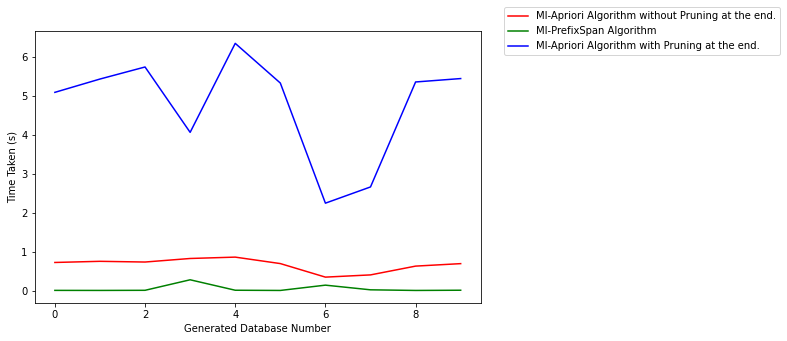

In [ ]:
plt.figure(figsize=(8,5))
plt.xlabel('Generated Database Number')
plt.ylabel('Time Taken (s)')
plt.plot(miapriori_times, color='red', label='MI-Apriori Algorithm without Pruning at the end.')
plt.plot(miprefixspan_times, color='green', label='MI-PrefixSpan Algorithm')
plt.plot(miapriori_pruning_times, color='blue', label='MI-Apriori Algorithm with Pruning at the end.')
plt.legend(bbox_to_anchor=(1.04,1), loc="center left")
plt.show()

# Compare for Different Length Item Sequences

In [ ]:
def compare(minsup,seed,lengths,file_name,apriorialg=True,prefixspanalg=True,aprioripruningalg=True,verbose=True):
  fig, axes = plt.subplots(len(lengths))
  axisIndex = 0
  for low, high in lengths:
    databases = []
    miapriori_times, miprefixspan_times, miapriori_pruning_times = [], [], []
    random.seed(seed)
    for i in range(10):
      n = max(10,random.choice(random.sample(list(range(100)), 10)))
      timeList = generate_time_list(n+1)
      items = generate_items(n)
      minLength = low
      maxLength = high
      dbLength = random.randint(minLength, maxLength)
      db = generate_database(items=items, timeList=timeList, minLength=minLength, maxLength=maxLength, dbLength=dbLength)
      databases.append(db)
    for i, db in enumerate(databases):
      if apriorialg:
        apriori = MultiTimeIntervalApriori(db=db, timeIntervals=TIME_INTERVALS, min_support=minsup)
        apriori.run_multi_time_interval_apriori()
        miapriori_times.append(apriori.find_time_taken())
      if prefixspanalg:
        prefixSpan = MultiTimeIntervalPrefixSpan(db=db, timeIntervals=TIME_INTERVALS, min_support=minsup)
        prefixSpan.runPrefixSpan()
        miprefixspan_times.append(prefixSpan.find_time_taken())
      if aprioripruningalg:
        apriori2 = MultiTimeIntervalApriori2(db=db, timeIntervals=TIME_INTERVALS, min_sup=minsup)
        apriori2.run_apriori()
        miapriori_pruning_times.append(apriori2.find_time_taken())
    # print(miapriori_times)
    # print(miprefixspan_times)
    # print(miapriori_pruning_times)
    axes[axisIndex].set_xlabel('Generated Database Number (Min_Sequence_Length: {0}, Max_Sequence_Length: {1})'.format(low, high))
    axes[axisIndex].set_ylabel('Time Taken (s)')
    axes[axisIndex].plot(miapriori_times, color='red', label='MI-Apriori Algorithm without Pruning at the end.')
    axes[axisIndex].plot(miprefixspan_times, color='green', label='MI-PrefixSpan Algorithm')
    axes[axisIndex].plot(miapriori_pruning_times, color='blue', label='MI-Apriori Algorithm with Pruning at the end.')
    axisIndex += 1
  handles, labels = axes[-1].get_legend_handles_labels()
  fig.legend(handles, labels,bbox_to_anchor=(1, 1.06), loc='upper right')
  fig.set_size_inches(10,10)
  if verbose:
    fig.tight_layout()
    fig.show()
  fig.savefig(file_name)
  

In [ ]:
lengths = [(1,10),(10,20),(20,30)]

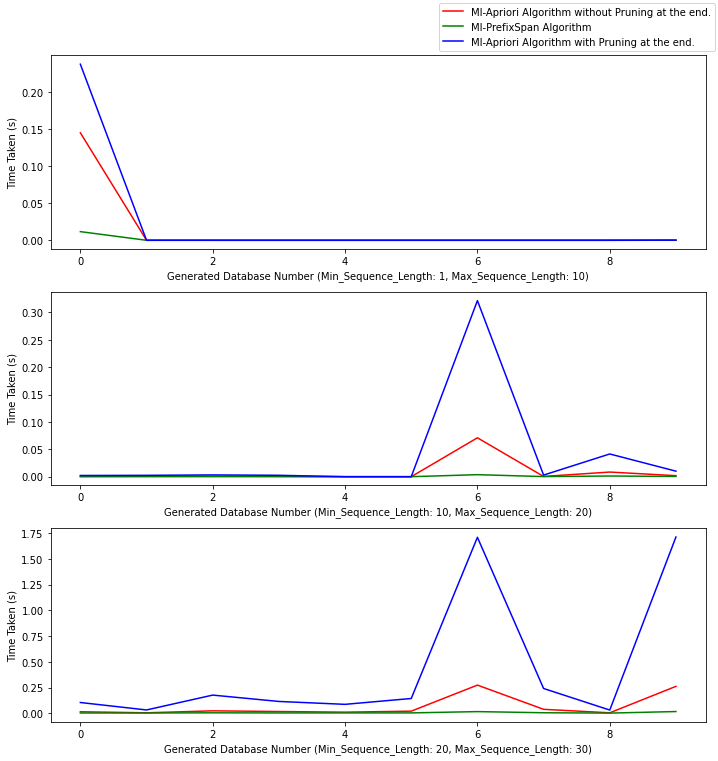

In [ ]:
compare(0.75,5,lengths,file_name='Three_Algorithms.pdf')

# Comparison of Apriori and PrefixSpan

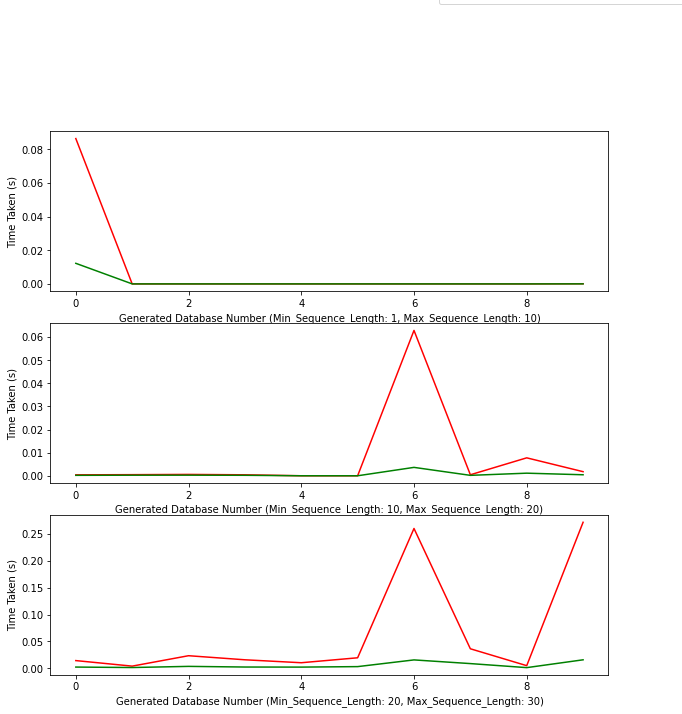

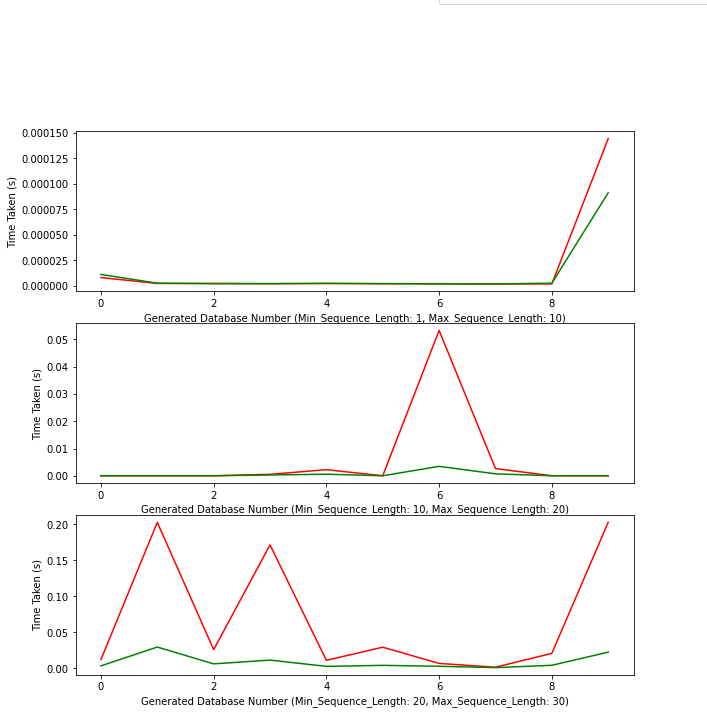

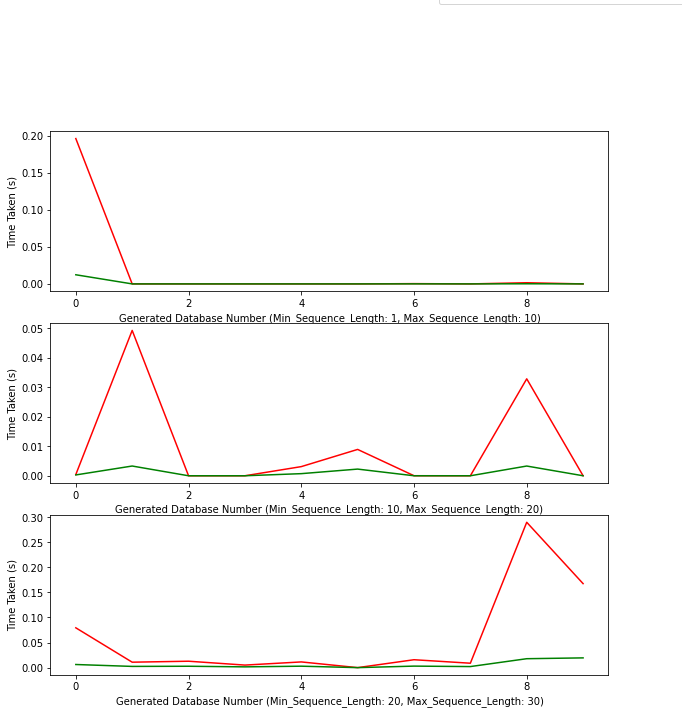

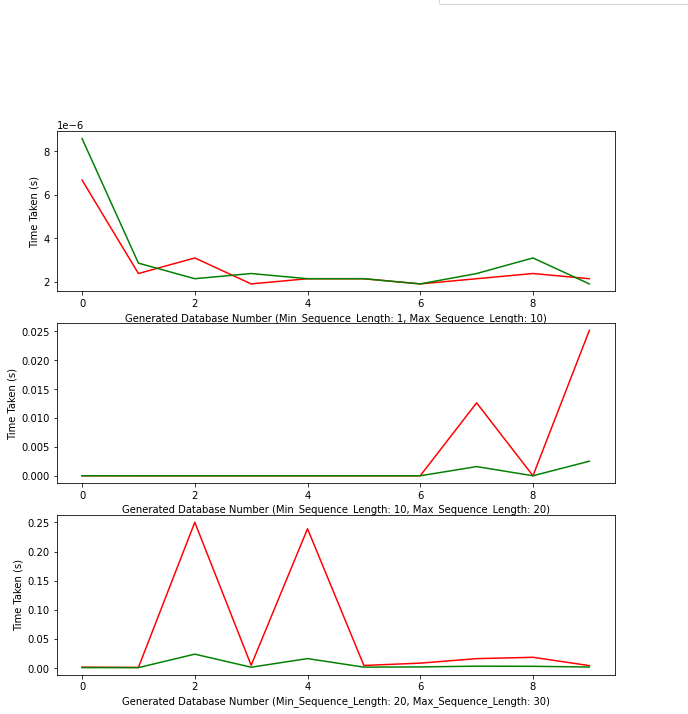

In [ ]:
compare(0.75,5,lengths,file_name='Apriori&PrefixSpan1.pdf',verbose=False,aprioripruningalg=False)
compare(0.75,10,lengths,file_name='Apriori&PrefixSpan2.pdf',verbose=False,aprioripruningalg=False)
compare(0.75,15,lengths,file_name='Apriori&PrefixSpan3.pdf',verbose=False,aprioripruningalg=False)
compare(0.75,20,lengths,file_name='Apriori&PrefixSpan4.pdf',verbose=False,aprioripruningalg=False)

# Comparison of Apriori Algorithm with and without pruning

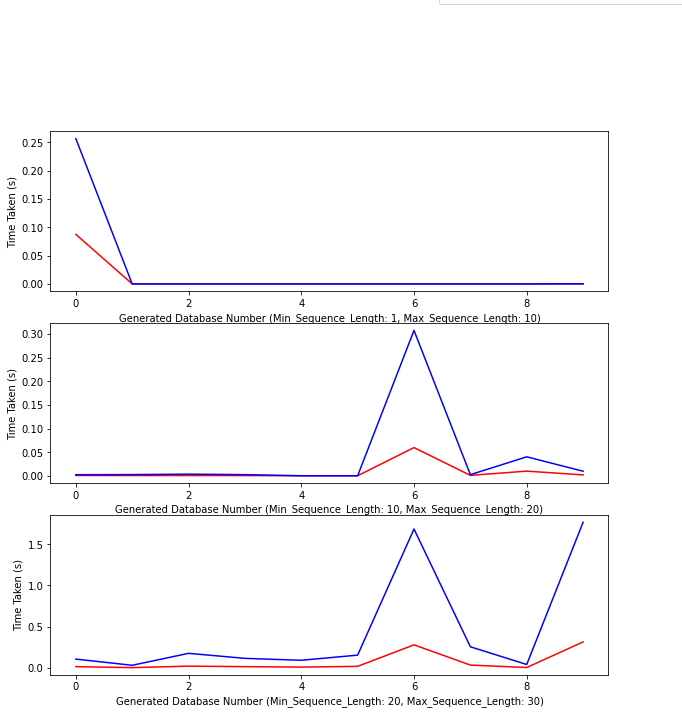

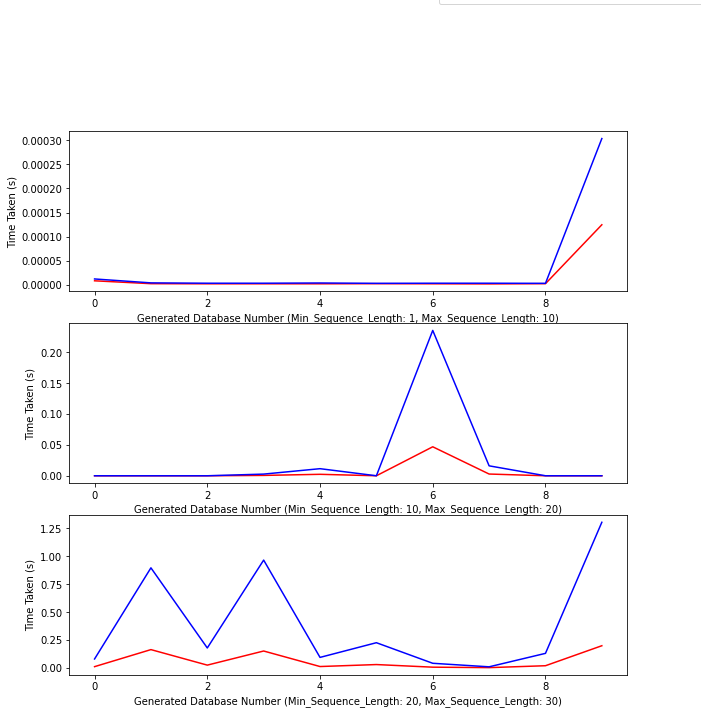

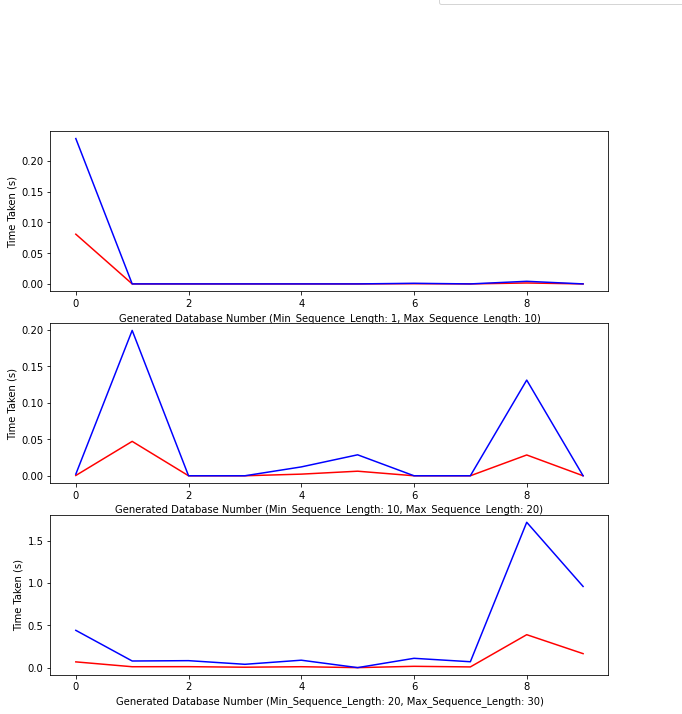

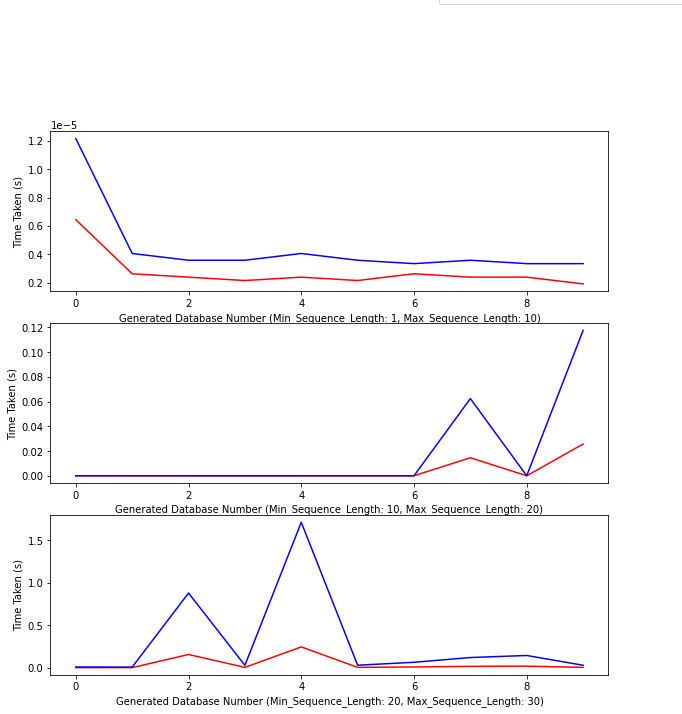

In [ ]:
compare(0.75,5,lengths,file_name='AprioriWith&WithoutPruning1.pdf',verbose=False,prefixspanalg=False)
compare(0.75,10,lengths,file_name='AprioriWith&WithoutPruning2.pdf',verbose=False,prefixspanalg=False)
compare(0.75,15,lengths,file_name='AprioriWith&WithoutPruning3.pdf',verbose=False,prefixspanalg=False)
compare(0.75,20,lengths,file_name='AprioriWith&WithoutPruning4.pdf',verbose=False,prefixspanalg=False)